In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

import warnings
warnings.filterwarnings("ignore")

In [126]:
x = np.ones((5,3))
y = np.ones((5,3)) * 2

x[:,:,None] @ x[:,:,None].T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

In [137]:
x = np.ones(5)
y = np.ones(5) * 2

x[:,None] @ x[:,None].T

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [2]:
def MMD(x: np.ndarray, y: np.ndarray, kernel: str):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

       Both samples are d-dimensional

    Args:
        x: first samples, distribution P
        y: second samples, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = x[:,:,None] @ x[:,:,None].T, y[:,:,None] @ y[:,:,None].T, x[:,:,None] @ y[:,:,None].T
    rx = np.broadcast_to(np.expand_dims(np.diag(xx), 0), xx.shape)
    ry = np.broadcast_to(np.expand_dims(np.diag(yy), 0), yy.shape)

    dxx = rx.T + rx - 2. * xx
    dyy = ry.T + ry - 2. * yy
    dxy = rx.T + ry - 2. * zz
    
    XX = np.zeros(xx.shape)
    YY = np.zeros(yy.shape)
    XY = np.zeros(xx.shape)

    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += np.exp(-0.5*dxx/a)
            YY += np.exp(-0.5*dyy/a)
            XY += np.exp(-0.5*dxy/a)

    return np.mean(XX + YY - 2. * XY)

In [77]:
MMD(np.array([1,2,3]), np.array([1000,1000,10000]), 'rbf')

6.072698104628811

In [78]:
def normal_ppf(mean, std):
    return lambda q, mean = mean, std = std : norm.ppf(q, loc = mean, scale = std)

def get_user_user_distances_row(data_table, mask, row):
    rows, cols, samples = data_table.shape
    dists = np.zeros(rows)
    for i in range(rows):
        if i == row:
            dists[i] = np.inf
            continue
        dist = 0
        count = 0
        for j in range(cols):
            if mask[row,j] == 1 and mask[i,j] == 1:
                dist += MMD(data_table[row,j,:], data_table[i,j,:], 'rbf')
                count += 1
        dists[i] = dist / count
    return dists

def estimate_row(data_table, mask, col, row_dists, eta):
    """
    Vectorized version of nearest neighbors.
    Assumes data_table is a 3D numpy array.
    Assumes mask is a 2D numpy array.
    
    Assumes data is already sorted.
    """
    NN = row_dists < eta # threshold to get nearest neighbors
    
    if np.sum(NN) > 0:
        masked = (NN * mask[:,col]) == 1 # need the ==1 to convert back to booleans
        return np.concatenate(data_table[masked,col,:])
    else:
        return [0]

def generate_table(num_rows, num_cols, num_samples):
    # Table of n x m Gaussians with columns having same variance and rows having same means
    true_dists = {}
    mean_rows = np.random.uniform(-5,5,num_rows)
    std_cols = np.random.uniform(1,5,num_rows)
    data_table = np.zeros((num_rows, num_cols, num_samples))

    for i, j in product(range(num_rows), range(num_cols)):
        data_table[i,j,:] = np.sort(np.random.normal(mean_rows[i], std_cols[j], num_samples))
        true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])
    
    return data_table, true_dists, mean_rows, std_cols

def empirical_mmd():
    pass

def simulate_nn_location_scale(num_rows: int, num_cols: int, num_samples: int, n_runs: int):
    np.random.seed(0)
    error_est = []
    error_observed = []

    for _ in tqdm(range(n_runs)):
        data_table, true_dists, mean_rows, std_cols = generate_table(num_rows, num_cols, num_samples)

        # Generate mask
        mask = np.ones((num_rows,num_cols)).astype(int)
        mask[0,0] = 0
        
        # eta = search_eta(data_table, mask, 3)
        eta = 1.0

        # Get user distances for just one row
        d = get_user_user_distances_row(data_table, mask, 0)
        est_dist = estimate_row(data_table, mask, 0, d, 0.1)
        
        # error_est.append(empirical_quantile(est_dist), true_dists[0,0])
        # error_observed.append(wasserstein2(empirical_quantile(data_table[0,0]), true_dists[0,0]))

    return error_est, error_observed

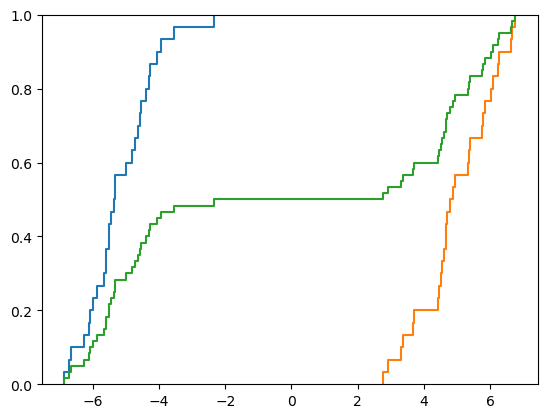

In [114]:
data1 = np.random.normal(-5,1,30)
data2 = np.random.normal(5,1,30)

plt.ecdf(data1)
plt.ecdf(data2)
plt.ecdf(np.concatenate([data1, data2]))

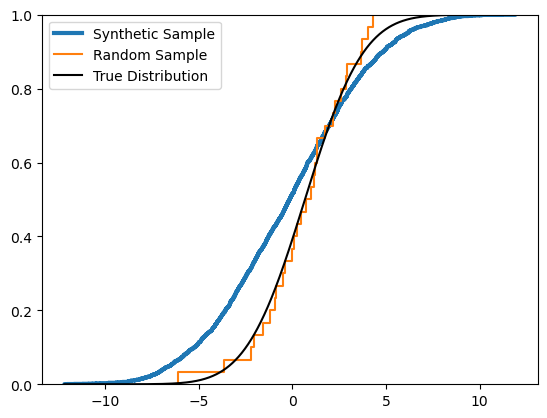

In [119]:
M = 100
N = 20
n = 30
data_table, true_dists, mean_rows, std_cols = generate_table(M,N,n)
mask = np.ones((M,N)).astype(int)
mask[0,0] = 0
d = get_user_user_distances_row(data_table, mask, 0)

est_dist = estimate_row(data_table, mask, 0, d, 100)

est_dist = np.sort(est_dist)

plt.ecdf(est_dist, linewidth=3)
x_min = np.min(est_dist)
x_max = np.max(est_dist)
x = np.linspace(x_min, x_max, num = 1000)
y = scipy.stats.norm.cdf(x, mean_rows[0], std_cols[0])
sample = np.random.normal(mean_rows[0], std_cols[0], n)
plt.ecdf(sample)
plt.plot(x,y, '-', c='k')

plt.legend(["Synthetic Sample", "Random Sample", "True Distribution"])